In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
plt.style.use('paper')

In [2]:
Mp = 1.e-8
def makesim(e=0.01, dtOverT = 0.01):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=Mp, P=1., e=e)
    sim.move_to_com()
    sim.dt = dtOverT*sim.particles[1].P

    return sim

In [5]:
%%time
Nout = 1000
e=0.1
dtOverT = 0.001
taua = 1000
tmax = 3*taua

times = np.linspace(0, tmax, Nout)

simKD = makesim(e=e, dtOverT=dtOverT)
rebxKD = reboundx.Extras(simKD)
modKD = rebxKD.load_force("modify_orbits_forces")
rebxKD.add_force(modKD)

simKD.integrator = "none"
keplerKD = rebxKD.load_operator("kepler")
integforceKD = rebxKD.load_operator("integrate_force")
integforceKD.params['force'] = modKD
integforceKD.params['integrator'] = reboundx.integrators["rk4"]
rebxKD.add_operator(keplerKD, dtfraction=0.5, timing="post")
rebxKD.add_operator(integforceKD, dtfraction=1., timing="post")
rebxKD.add_operator(keplerKD, dtfraction=0.5, timing="post")
simKD.particles[1].params['tau_a'] = -taua

sim = makesim(e=e, dtOverT=dtOverT)
sim.integrator = "ias15"
rebx = reboundx.Extras(sim)
mod = rebx.load_force("modify_orbits_forces")
rebx.add_force(mod)
sim.particles[1].params['tau_a'] = -taua

EsKD, Es = np.zeros(Nout), np.zeros(Nout)
P = np.zeros(Nout)

for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time=0)
    sim.integrate(simKD.steps_done*simKD.dt)
    
    Es[i] = sim.calculate_energy()
    EsKD[i] = simKD.calculate_energy()
    P[i] = sim.particles[1].P

CPU times: user 47.9 s, sys: 12.3 ms, total: 47.9 s
Wall time: 47.9 s


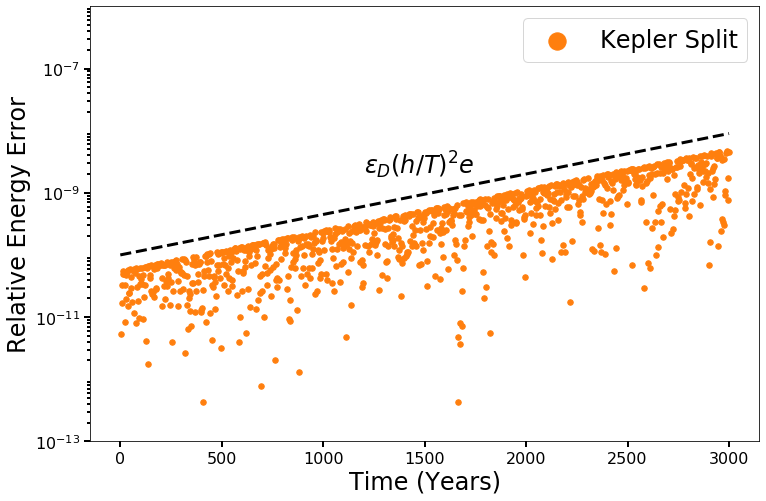

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
s=30
#ax.scatter(times, np.abs((EsMIS-Es)/Es), s=s, label='Modified Integration Scheme')
ax.scatter(0,0) # dummy to keep color same
ax.scatter(times, np.abs((EsKD-Es)/Es), s=s, label='Kepler Split')
ax.plot(times, P/taua *(simKD.dt/P)**2 * e, 'k--')
ax.text(1200, 2.e-9, r'$\epsilon_D (h/T)^2e$', fontsize=24)
ax.set_yscale('log')
ax.set_ylabel('Relative Energy Error', fontsize=24)
ax.set_xlabel('Time (Years)', fontsize=24)
ax.set_ylim([1e-13, 1e-6])
lgnd = ax.legend(fontsize=24,loc='upper right', scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([300])
plt.rcParams["text.usetex"] = False
plt.locator_params(axis='y', numticks=5)

fig.savefig("fig3.pdf", bbox_inches='tight')